In [1]:
import numpy as np
import os
import math

from PIL import Image

# Clustering
from sklearn.cluster import KMeans                  # 2) K-Means
from sklearn.mixture import GaussianMixture         # 3) Gaussian Mixture Models

from sklearn.preprocessing import StandardScaler
# Evaluation
from sklearn import metrics
from skimage.measure import compare_mse
from sklearn.metrics import make_scorer

from sklearn.decomposition import PCA       # 2) PCA
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV

import matplotlib.pyplot as plt 
%matplotlib inline
import newscripts as myutils

Using TensorFlow backend.


In [2]:
# Load training data

train_directory = "../../Data/Kather_all_train"
namesandvalues = myutils.loadData(train_directory)
X_train = np.asarray(namesandvalues[0])
train_image_names = namesandvalues[1]

y_train = myutils.loadLabelsFromsubdirectoryindex(train_image_names, "../../Data/Kather_original_train")

In [3]:
print(X_train.shape)
len(y_train)

(4200, 150, 150, 3)


4200

In [4]:
# Load testing data

test_directory = "../../Data/Kather_all_test"
namesandvalues = myutils.loadData(test_directory)
X_test = np.asarray(namesandvalues[0])
test_image_names = namesandvalues[1]

y_test = myutils.loadLabelsFromsubdirectoryindex(test_image_names, "../../Data/Kather_original_test")

In [5]:
print(X_test.shape)
len(y_test)

(800, 150, 150, 3)


800

In [6]:
# Reshape Scale data
X_train = X_train.reshape(X_train.shape[0] , -1) # Reshape for scaling
X_test = X_test.reshape(X_test.shape[0] , -1) # Reshape for scaling

scaled_X_train = StandardScaler().fit_transform(X_train)
scaled_X_test = StandardScaler().fit_transform(X_test)

In [7]:
"""
how the .... even after stratification, meaning that the testing and the training datasets have the same classes breakdown
the dimensions for 99% variance for the training set is DIFFERENT than the dimensions for 99% variance of the testing set

size shouldnt make a difference, cuz this is for each image......?
"""

'\nhow the .... even after stratification, meaning that the testing and the training datasets have the same classes breakdown\nthe dimensions for 99% variance for the training set is DIFFERENT than the dimensions for 99% variance of the testing set\n\nsize shouldnt make a difference, cuz this is for each image......?\n'

In [8]:
print(scaled_X_train.shape)
scaled_X_test.shape

(4200, 67500)


(800, 67500)

In [9]:
# Reduce Dimensions
# PCA 
pca1 = PCA(n_components=750)
transformed_train = pca1.fit_transform(scaled_X_train)

pca2 = PCA(n_components=750)
transformed_test = pca2.fit_transform(scaled_X_test)


In [10]:
print(sum(pca1.explained_variance_ratio_))
sum(pca2.explained_variance_ratio_)

0.9641286009836204


0.9999756396235794

In [11]:
# Fit on training data
kmeans = KMeans(n_clusters=8).fit(transformed_train)
print('kmeans Silhouette Score  {} '.format(metrics.silhouette_score(transformed_train, kmeans.labels_)))

gmm = GaussianMixture(n_components=8, covariance_type='full').fit(transformed_train)
gmmlabels_ = gmm.predict(transformed_train)
print('gmm Silhouette Score  {} '.format(metrics.silhouette_score(transformed_train, gmmlabels_)))

# Predict on testing
kmeans_labels = kmeans.predict(transformed_test)
gmm_labels = gmm.predict(transformed_test)

# training
print(metrics.completeness_score(y_train,kmeans.labels_))
print(metrics.completeness_score(y_train,gmmlabels_))

# testing
print(metrics.completeness_score(y_test,kmeans_labels))
print(metrics.completeness_score(y_test,gmm_labels))

kmeans Silhouette Score  0.18847064330569424 
gmm Silhouette Score  0.2015604125752637 
0.5073996545345579
0.4827780457223727
0.5425153672266099
1.0


In [12]:
# Evaluate on testing data using grid search  cv
parameters = {'covariance_type':('full', 'spherical', 'diag', 'tied'), 'n_components':[8],'random_state':[0,19,42]}
clf = GridSearchCV(GaussianMixture(), parameters, scoring=make_scorer(metrics.completeness_score))

clf.fit(transformed_train, y_train)
print(clf.best_estimator_)
print(clf.best_score_)

parameters = {'init':('k-means++', 'random'), 'n_clusters':[8],'random_state':[0,19,42]}
clf2 = GridSearchCV(KMeans(), parameters, scoring=make_scorer(metrics.completeness_score))

clf2.fit(transformed_train, y_train)
print(clf2.best_estimator_)
clf2.best_score_

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/mixture/_base.py:267: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/mixture/_base.py:267: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/mixture/_base.py:267: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/mixture/_base.py:267: ConvergenceWarning: Initialization

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
                means_init=None, n_components=8, n_init=1, precisions_init=None,
                random_state=42, reg_covar=1e-06, tol=0.001, verbose=0,
                verbose_interval=10, warm_start=False, weights_init=None)
1.0
KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=8, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=0, tol=0.0001, verbose=0)


0.508885657706834

In [13]:
# best estimator

gmm_best = GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
                means_init=None, n_components=8, n_init=1, precisions_init=None,
                random_state=0, reg_covar=1e-06, tol=0.001, verbose=0,
                verbose_interval=10, warm_start=False, weights_init=None).fit(transformed_train)

print(metrics.completeness_score(y_train , gmm_best.predict(transformed_train)))
print(metrics.completeness_score(y_test , gmm_best.predict(transformed_test)))

0.49890225829703555
1.0


In [14]:
kmeans_best = KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300, n_clusters=8,
       n_init=10, n_jobs=None, precompute_distances='auto', random_state=42,
       tol=0.0001, verbose=0).fit(transformed_train)

print(metrics.completeness_score(y_train , kmeans_best.predict(transformed_train)))
print(metrics.completeness_score(y_test , kmeans_best.predict(transformed_test)))

0.49799661496022646
0.5432809375095791


In [15]:
transformed_test.shape

(800, 750)

In [16]:
best_labels = gmm_best.predict(transformed_test)
print(best_labels.shape)

(800,)


In [17]:
len(test_image_names)

800

In [18]:
len(os.listdir(test_directory))

801

In [19]:
# Labels = myutils.ClusterAndPlot(8, transformedData)
myutils.clusterintoDirectories(kmeans_best.predict(transformed_test), test_directory, test_image_names)


In [20]:
from skimage.external import tifffile


In [21]:
def pltPathologyClusters(labels, path):
    # clusterimgDir = "../../Data/clusters_journal.PNG"
    # image = Image.open(clusterimgDir) 
    # plt.figure(figsize = (85,12))
    # plt.imshow(image)
    # plt.axis('off')
    
    sub_directories = [str(cluster) for cluster in set(labels)]
    displayImages = []
    fig = plt.figure(figsize=(14, 14))
    
#     print(len(sub_directories))
    x=1
    
    for cluster in sub_directories:
        direct = path + '/{}'.format(cluster)
#         print(len(os.listdir(direct)))
        if len(os.listdir(direct))-9 > 9: # if directory has less than 9 images set index to 0 else random index
            index = np.random.randint(9,len(os.listdir(direct))-9)
        else:
#             print("index is 0")
            index = 0 # pick the first 10 images
        clusterList = [] # reset the row
        for file in os.listdir(direct)[index:index+9]: # random sample of 9 images
            if file.endswith('.tif'):
                image = tifffile.imread(os.path.join(path, file))
                clusterList.append(image)
                displayImages.append(image) # list of ALL Images
                
        for i in range(1,9+1):
            if (len(clusterList) > i):
                img = clusterList[i-1]
            fig.add_subplot(8, 9, x)
            plt.imshow(img)
            plt.axis('off')
            plt.subplots_adjust(wspace=0.0, hspace=0.0)
            x+=1
        
    
    
#     columns = 9
#     rows = len(sub_directories)
    
#     print(len(displayImages))
#     print(columns*rows)
    
#     for i in range(1, columns*rows+1):
#         img = displayImages[i-1]
#         fig.add_subplot(rows, columns, i)
#         plt.imshow(img)
#         plt.axis('off')
#         plt.subplots_adjust(wspace=0.0, hspace=0.0)
    plt.show()
    

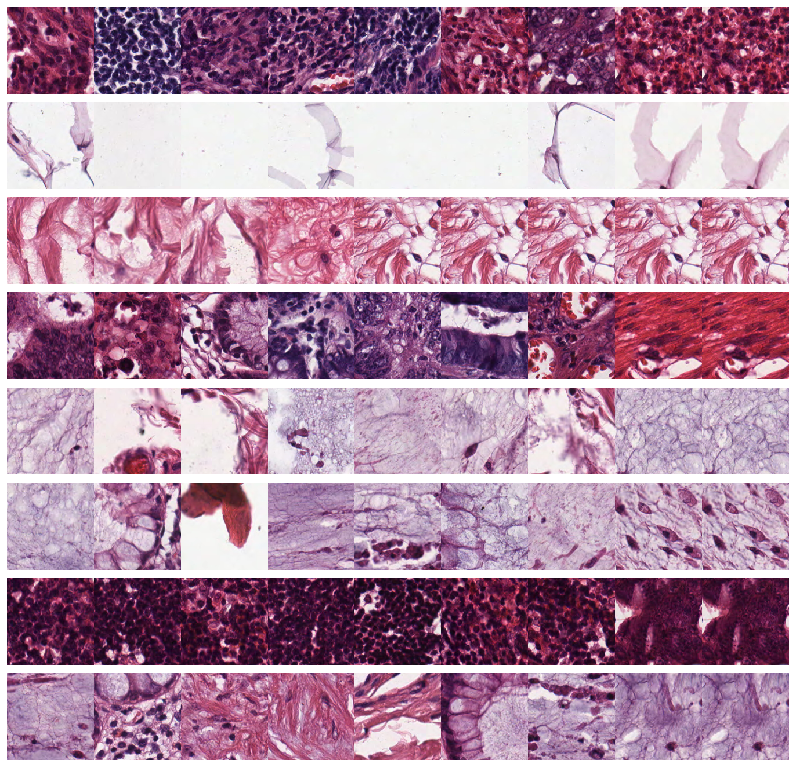

In [22]:
pltPathologyClusters(kmeans_best.predict(transformed_test), test_directory)

In [23]:
# Approach 2: manually selected features

In [24]:
# Load training data

train_directory = "../../Data/Kather_all_train"

train_mean_List = []
train_image_names = []

for filename in os.listdir(train_directory):
    if filename.endswith('tif') or filename.endswith('jpeg'):
        image = Image.open(os.path.join(train_directory, filename))
        train_image_names.append(filename)
        train_mean_List.append(myutils.calculateMeanHE(image) + myutils.calculateMeanRGB(image))

train_meanMatrix = np.asarray(train_mean_List)
y_train = myutils.loadLabelsFromsubdirectoryindex(train_image_names, "../../Data/Kather_original_train")


# testing
test_directory = "../../Data/Kather_all_test"

test_mean_List = []
test_image_names = []

for filename in os.listdir(test_directory):
    if filename.endswith('tif') or filename.endswith('jpeg'):
        image = Image.open(os.path.join(test_directory, filename))
        test_image_names.append(filename)
        test_mean_List.append(myutils.calculateMeanHE(image) + myutils.calculateMeanRGB(image))

test_meanMatrix = np.asarray(test_mean_List)
y_test = myutils.loadLabelsFromsubdirectoryindex(test_image_names, "../../Data/Kather_original_test")

In [25]:
# directory = "../../Data/Kather_all"

# mean_List = []
# image_names = []

# for filename in os.listdir(directory):
#     if filename.endswith('tif') or filename.endswith('jpeg'):
#         image = Image.open(os.path.join(directory, filename))
#         image_names.append(filename)
#         mean_List.append(myutils.calculateMeanHE(image) + myutils.calculateMeanRGB(image))

# meanMatrix = np.asarray(mean_List)
# labels_true = myutils.loadLabelsFromsubdirectoryindex(image_names, "../../Data/Kather_original")

# # Load testing data
# X_train, X_test, y_train, y_test = train_test_split(meanMatrix, labels_true, train_size=0.7, 
#                                                     test_size=0.2, random_state=42)


train_meanMatrix = train_meanMatrix.reshape(train_meanMatrix.shape[0] , -1) # Reshape for scaling
test_meanMatrix = test_meanMatrix.reshape(test_meanMatrix.shape[0] , -1) # Reshape for scaling

scaled_X_train = StandardScaler().fit_transform(train_meanMatrix)
scaled_X_test = StandardScaler().fit_transform(test_meanMatrix)

In [26]:
# Fit on training data
kmeans = KMeans(n_clusters=8, random_state=0).fit(scaled_X_train)
print('kmeans Silhouette Score  {} '.format(metrics.silhouette_score(scaled_X_train, kmeans.labels_)))

gmm = GaussianMixture(n_components=8, covariance_type='full').fit(scaled_X_train)
gmmlabels_ = gmm.predict(scaled_X_train)
print('gmm Silhouette Score  {} '.format(metrics.silhouette_score(scaled_X_train, gmmlabels_)))

# Predict on testing
kmeans_labels = kmeans.predict(scaled_X_test)
gmm_labels = gmm.predict(scaled_X_test)

# training
print(metrics.completeness_score(y_train,kmeans.labels_))
print(metrics.completeness_score(y_train,gmmlabels_))

# testing
print(metrics.completeness_score(y_test,kmeans_labels))
print(metrics.completeness_score(y_test,gmm_labels))

kmeans Silhouette Score  0.4759705711157182 
gmm Silhouette Score  0.2958892255479576 
0.561899116052635
0.5354653410490762
0.5823315791755752
0.5345396200649495


In [27]:
# Evaluate on testing data using grid search  cv
parameters = {'covariance_type':('full', 'spherical', 'diag', 'tied'), 'n_components':[8],'random_state':[0,19,42]}
clf = GridSearchCV(GaussianMixture(), parameters, scoring=make_scorer(metrics.completeness_score))

clf.fit(scaled_X_train, y_train)
print(clf.best_estimator_)
print(clf.best_score_)

parameters = {'init':('k-means++', 'random'), 'n_clusters':[8],'random_state':[0,19,42]}
clf2 = GridSearchCV(KMeans(), parameters, scoring=make_scorer(metrics.completeness_score))

clf2.fit(scaled_X_train, y_train)
print(clf2.best_estimator_)
clf2.best_score_

GaussianMixture(covariance_type='spherical', init_params='kmeans', max_iter=100,
                means_init=None, n_components=8, n_init=1, precisions_init=None,
                random_state=0, reg_covar=1e-06, tol=0.001, verbose=0,
                verbose_interval=10, warm_start=False, weights_init=None)
0.6036901334409069
KMeans(algorithm='auto', copy_x=True, init='random', max_iter=300, n_clusters=8,
       n_init=10, n_jobs=None, precompute_distances='auto', random_state=19,
       tol=0.0001, verbose=0)


0.5693855371224906

In [28]:
# Reduce Dimensions
# PCA 
pca1 = PCA(n_components=2)
transformed_train = pca1.fit_transform(scaled_X_train)

pca2 = PCA(n_components=2)
transformed_test = pca2.fit_transform(scaled_X_test)


In [29]:
gmm_best = GaussianMixture(covariance_type='spherical', init_params='kmeans', max_iter=100,
                means_init=None, n_components=8, n_init=1, precisions_init=None,
                random_state=0, reg_covar=1e-06, tol=0.001, verbose=0,
                verbose_interval=10, warm_start=False, weights_init=None).fit(transformed_train)
gmm_labels = gmm_best.predict(transformed_test)
print(metrics.completeness_score(y_test,gmm_labels))

0.6336020376419544


In [30]:
print(metrics.completeness_score(y_train,gmm_best.predict(transformed_train)))

0.5949179675628853


In [31]:
k_best = KMeans(algorithm='auto', copy_x=True, init='random', max_iter=300, n_clusters=8,
       n_init=10, n_jobs=None, precompute_distances='auto', random_state=19,
       tol=0.0001, verbose=0).fit(transformed_train)

k_labels = k_best.predict(transformed_test)
print(metrics.completeness_score(y_test,k_labels))

0.6159876406955158


In [32]:
print(k_labels.shape)
print(len(os.listdir(test_directory)))
len(test_image_names)

(800,)
809


800

In [33]:
import shutil

def symlink_rel(src, dst):
    rel_path_src = os.path.relpath(src, os.path.dirname(dst))
    os.symlink(rel_path_src, dst)
    
def clusterintoDirectories(labels, path, imagenamesList):
    # remove existing subdirectories first to avoid overlap
    sub_directories = [str(i) for i in range(len(set(labels))+1)]

    for cluster in sub_directories:
        if (cluster in os.listdir(path)) and (os.path.isdir(os.path.join(path , cluster))):
            shutil.rmtree(os.path.join(path , cluster))

    for filename in os.listdir(path):
        if filename.endswith('.tif'):
            for cluster in sub_directories: # count of distinct elements = no. of clusters
                os.makedirs(path + '/{}'.format(cluster) , exist_ok=True)
    
#     print(len(imagenamesList))
#     print(sub_directories)
#     print(len(labels))
    
    for i in range(len(imagenamesList)):
#         print(i)
        # if there isnt already a symlink of this image in the coressponding subdirectory
#         print(labels[i])
        if imagenamesList[i] not in os.listdir(path + '/' + sub_directories[labels[i]]): 
            symlink_rel(path + '/{}'.format(imagenamesList[i]) , 
                       path + '/{}'.format(labels[i]) + '/' + imagenamesList[i])

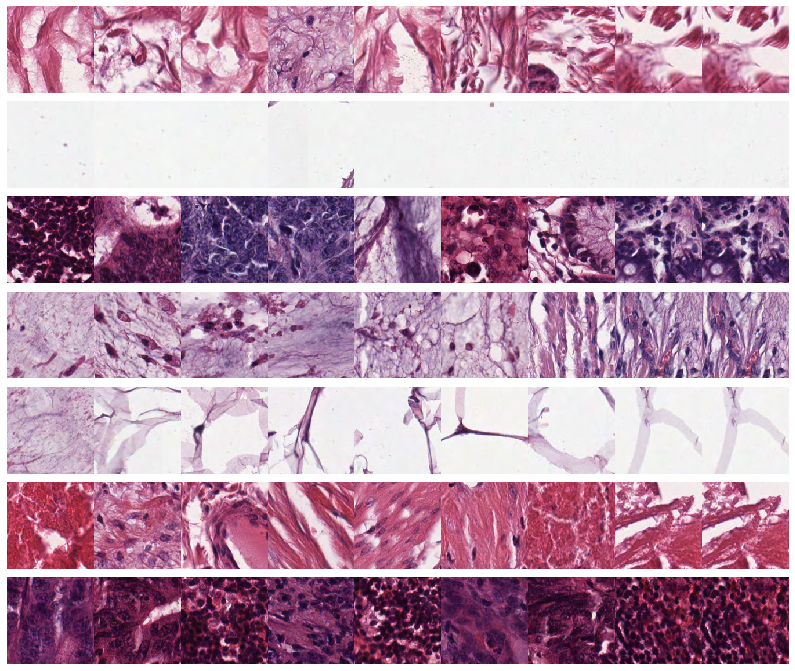

In [34]:
clusterintoDirectories(gmm_labels, test_directory, test_image_names)
pltPathologyClusters(gmm_labels, test_directory)

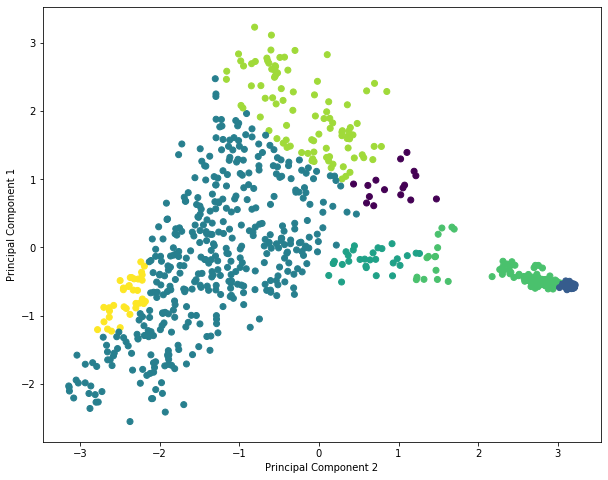

In [35]:
plt.figure(figsize=(10, 8))
plt.ylabel('Principal Component 1')
plt.xlabel('Principal Component 2')
plt.scatter(transformed_test[:, 0], transformed_test[:, 1], c=gmm_labels, cmap='viridis')